In [1]:
from plotting.visutil import CSVPlotter
from plotting.postprocess import PostProcessor
from config.plotsetting import object_dict
import pandas as pd
%load_ext autoreload
%autoreload 2

## Produce ABCD table

Region A is defined as: OS + 2 b-tagged \
Region B is defined as: OS + 1 b-tagged \
Region C is defined as: SS + 2 b-tagged \
Region D is defined as: SS + 1 b-tagged

In [2]:
def add_inv_mass(df):
    # get deltaR and select OS
    from analysis.objutil import Object
    df.rename(columns=lambda x: x.replace('LDTau', 'LeadingTau'), inplace=True)
    df.rename(columns=lambda x: x.replace('SDTau', 'SubleadingTau'), inplace=True)
    leading_tau = Object.fourvector(df, 'LeadingTau', sort=False)
    subleading_tau = Object.fourvector(df, 'SubleadingTau', sort=False)
    df['Tau_dR'] = leading_tau.deltaR(subleading_tau)
    ld_jet = Object.fourvector(df, 'LDBjetBYtag', sort=False)
    sd_jet = Object.fourvector(df, 'SDBjetBYtag', sort=False)
    df['Bjet_dR'] = ld_jet.deltaR(sd_jet)
    df['Tau_InvM'] = (leading_tau+subleading_tau).mass
    df['Bjet_InvM'] = (ld_jet+sd_jet).mass

In [3]:
def selOS(df):
    add_inv_mass(df)
    OS_cond = (df['LeadingTau_charge']*df['SubleadingTau_charge'] < 0)
    OS_df = df[OS_cond]
    return OS_df

def selSS(df):
    add_inv_mass(df)
    SS_cond = (df['LeadingTau_charge']*df['SubleadingTau_charge'] > 0)
    SS_df = df[SS_cond]
    return SS_df

In [4]:
cp = CSVPlotter(outdir='/Users/yuntongzhou/Desktop/Dihiggszztt/output/plots')
dfB = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_onelooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selOS, selname='OS Tau')
dfA = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_twolooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selOS, selname='OS Tau')

In [5]:
# calculate total cutflow
inputpath1='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_onelooseb_extrasel'
PostProcessor.merge_cf(inputdir=inputpath1, outputdir=f'{inputpath1}')
inputpath2='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_twolooseb_extrasel'
PostProcessor.merge_cf(inputdir=inputpath2, outputdir=f'{inputpath2}')

In [6]:
def ABCDTable():
    AC_df = pd.read_csv(f'{inputpath2}/scaledyield.csv')
    AC_df.drop(columns=['Sig Eff', 'Bkg Eff'], inplace=True)
    AC_df = AC_df.apply(pd.to_numeric, errors='coerce')
    BD_df = pd.read_csv(f'{inputpath1}/scaledyield.csv')
    BD_df = BD_df.apply(pd.to_numeric, errors='coerce')
    BD_df.drop(columns=['Sig Eff', 'Bkg Eff'], inplace=True)
    A_row = AC_df.iloc[-1]
    C_row = AC_df.iloc[-2]-AC_df.iloc[-1]
    B_row = BD_df.iloc[-1]
    D_row = BD_df.iloc[-2]-BD_df.iloc[-1]
    ABCD_tab = pd.DataFrame([A_row, B_row, C_row, D_row])
    ABCD_tab['SvB Ratio'] = ABCD_tab['Tot Sig']/ABCD_tab['Tot Bkg']
    ABCD_tab.index = ['Region A', 'Region B', 'Region C', 'Region D']
    ABCD_tab = ABCD_tab.dropna(axis=1, how='any')
    ABCD_tab.to_csv('/Users/yuntongzhou/Desktop/Dihiggszztt/output/ABCD.csv')
    return ABCD_tab

In [7]:
ABCDTable()

,DYJets,QCD,SingleH,TTbar,WW,WWW,WZ,Tot Bkg,ggF,ZH,ZZ,Tot Sig,SvB Ratio
Region A,2717.323374,6870.572808,66.115697,7736.136462,11.459262,0.456698,58.852421,17460.916721,6.750726,12.745013,21.783755,41.279495,0.002364
Region B,13509.347012,32649.645704,331.119851,5400.680737,72.579425,3.234945,297.673912,52264.281586,3.453490,6.892095,49.916684,60.262270,0.001153
Region C,90.148169,6188.520430,5.339008,836.394924,2.465687,0.342524,9.208294,7132.419035,0.182935,0.296335,1.501624,1.980895,0.000278
Region D,785.576900,33126.873705,10.095773,855.988958,10.353424,1.674560,52.668599,34843.231919,0.097927,0.271375,4.743538,5.112840,0.000147


In [8]:
dfD = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_onelooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selSS, selname='SS Tau')
dfC = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_twolooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selSS, selname='SS Tau')

## Make Plots for Background vs Signal Distribution in four regions

In [23]:
from config.plotsetting import tau_gen, bjetbytag_btag, H_mass

In [13]:
bkg_only = {"DYJets": ["DYJets"], "TTbar": ["TTbar"], "SingleH": ["SingleH"], "Others": ["WZ", "WWW", "WW"], "QCD": ["QCD"]}
sig_only = {"ZH": ["ZH"], "ggF": ["ggF"], "ZZ": ["ZZ"]}
sig_total = {"Signal x 10": ["ZH", "ggF", "ZZ"]}
QCD_excluded = {"DYJets": ["DYJets"], "TTbar": ["TTbar"], "SingleH": ["SingleH"], "Others": ["WZ", "WWW", "WW"]}

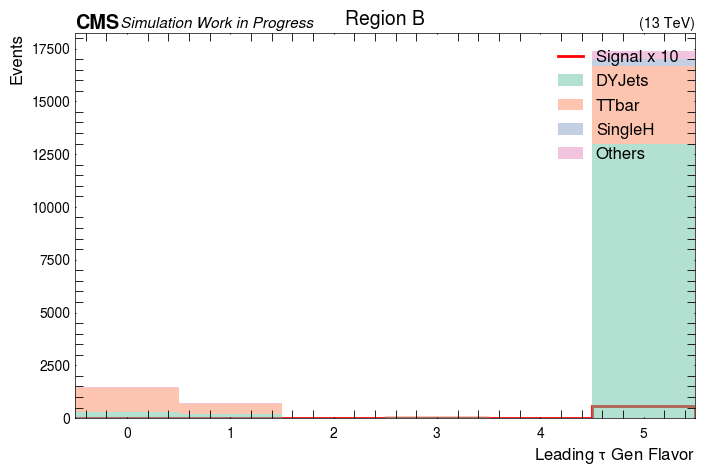

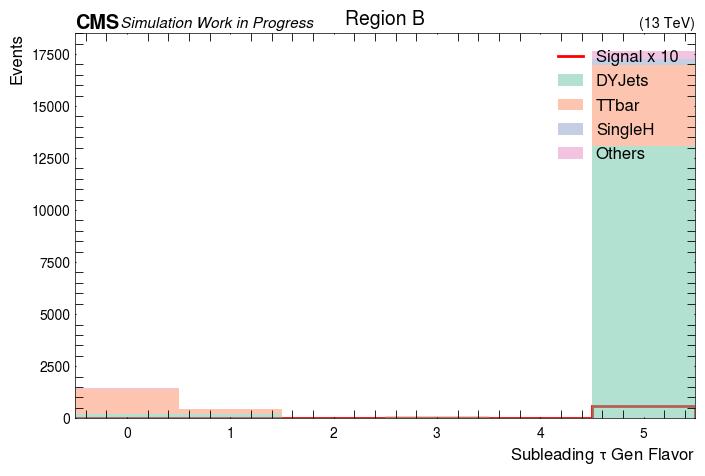

In [27]:
cp.plot_SVB(dfB, tau_gen, sgroup=sig_total, bgroup=QCD_excluded, title='Region B', save_name='_RegionB')

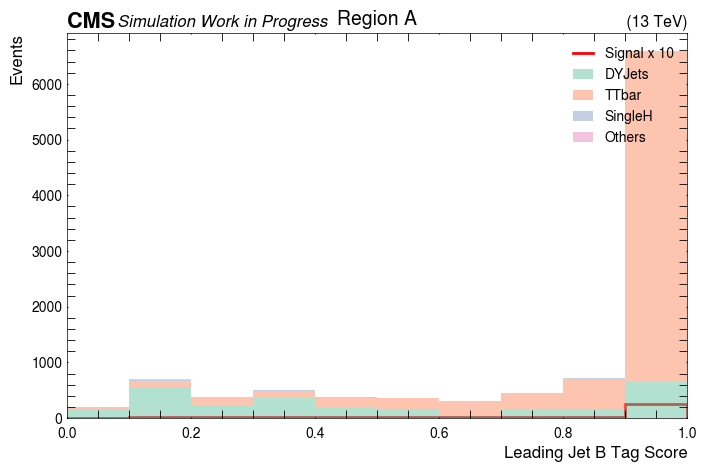

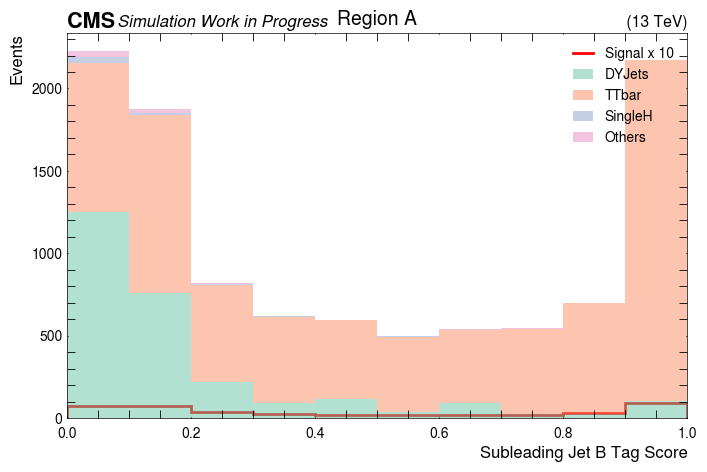

In [15]:
cp.plot_SVB(dfA, bjetbytag_btag, sgroup=sig_total, bgroup=QCD_excluded, title='Region A', save_name='_RegionA')

## Make Plots for Background Distribution in four regions

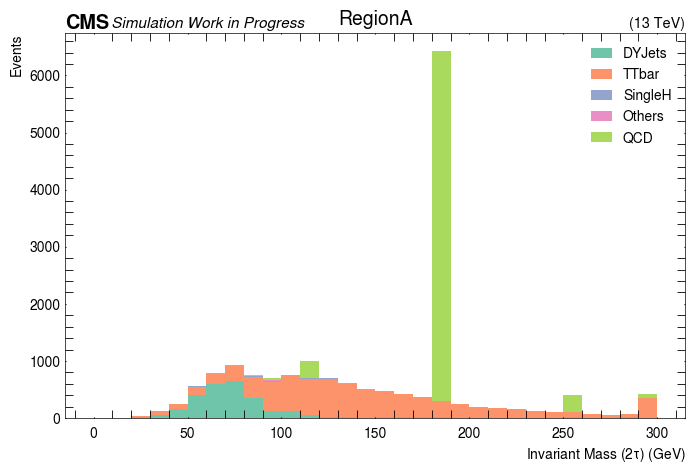

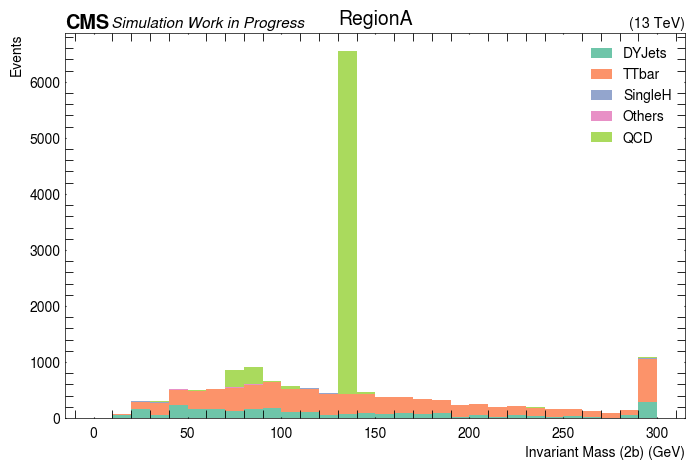

In [39]:
# See difference in Region A and Region B
cp = CSVPlotter("/Users/yuntongzhou/Desktop/Dihiggszztt/output/plots")
cp.plot_hist(dfA, H_mass, group=bkg_only, title='RegionA', save_name='_RegionA')

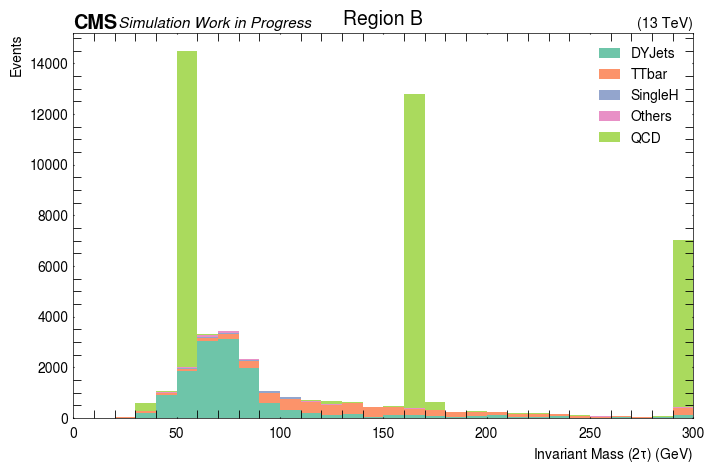

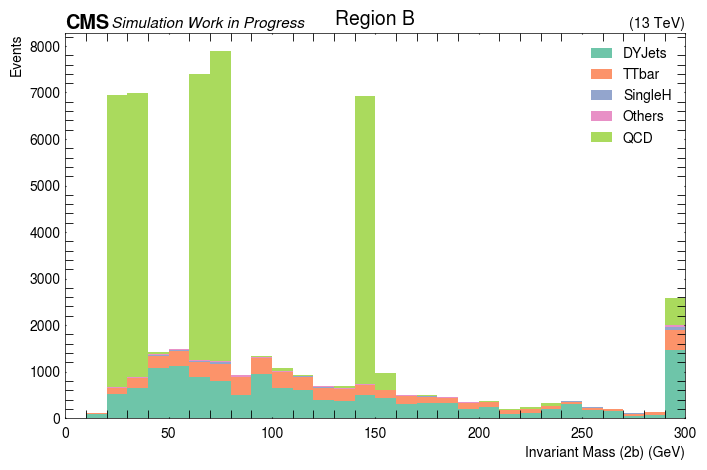

In [52]:
cp.plot_hist(dfB, H_mass, group=bkg_only, title='Region B', save_name='_RegionB')

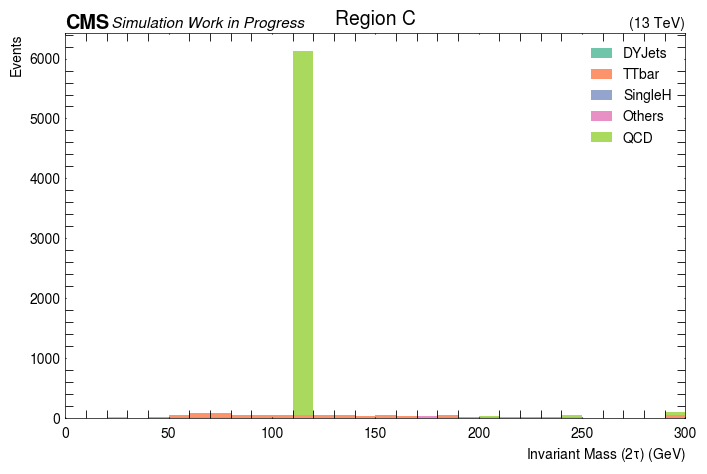

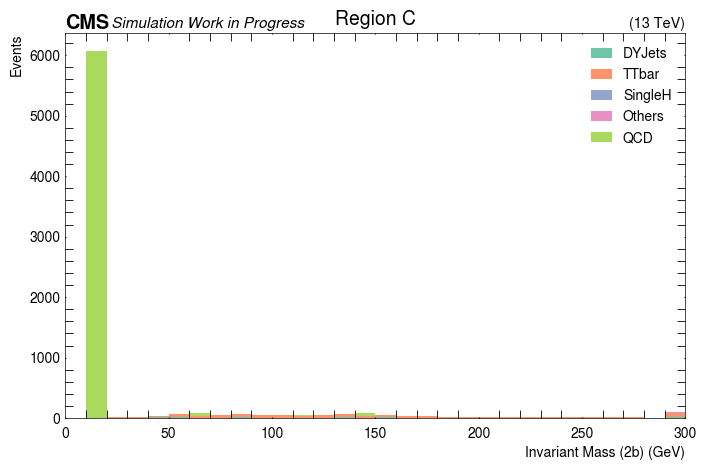

In [53]:
# See difference in Region C and Region D
cp = CSVPlotter("/Users/yuntongzhou/Desktop/Dihiggszztt/output/plots")
cp.plot_hist(dfC, H_mass, group=bkg_only, title='Region C', save_name='_RegionC')

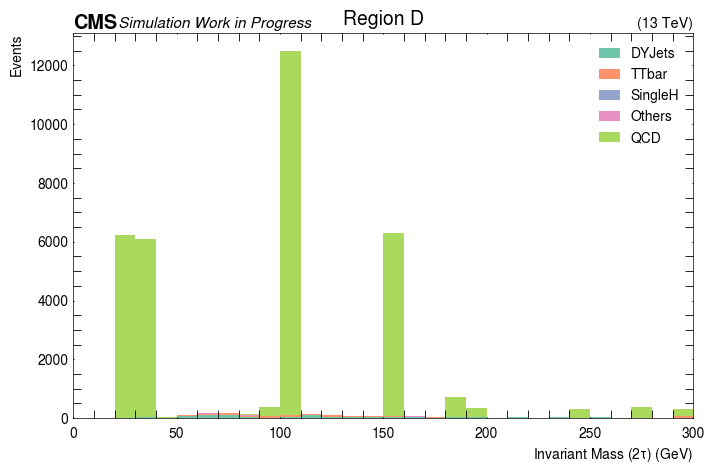

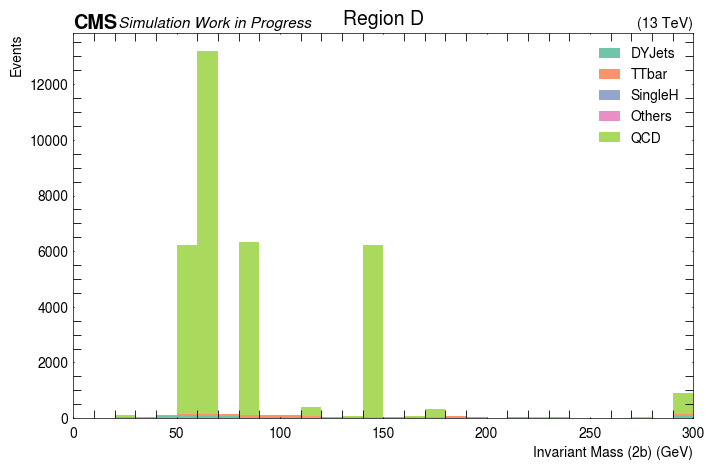

In [54]:
cp.plot_hist(dfD, H_mass, group=bkg_only, title='Region D', save_name='_RegionD')

## Add CSV cutflows

## Make plots

In [39]:
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
finame = '/Users/yuntongzhou/Desktop/Dihiggszztt/output/hadded/prelim_looseb/datasource/processed.csv'
df = pd.read_csv(finame, index_col=0)

In [33]:
sig_sep = {"DYJets": ["DYJets"], "ZH": ["ZH"], "ggF": ["ggF"], "TTbar": ["TTbar"], "ZZ": ["ZZ"], 
         "SingleH": ["SingleH"],
         "Others": ["WZ", "WWW", "WW"]}

In [48]:
svb_grp = 

In [35]:
group = {"DYJets": ["DYJets"],
         "SingleH": ["SingleH"],
         "ZH": ["ZH"], "ggF": ["ggF"]}

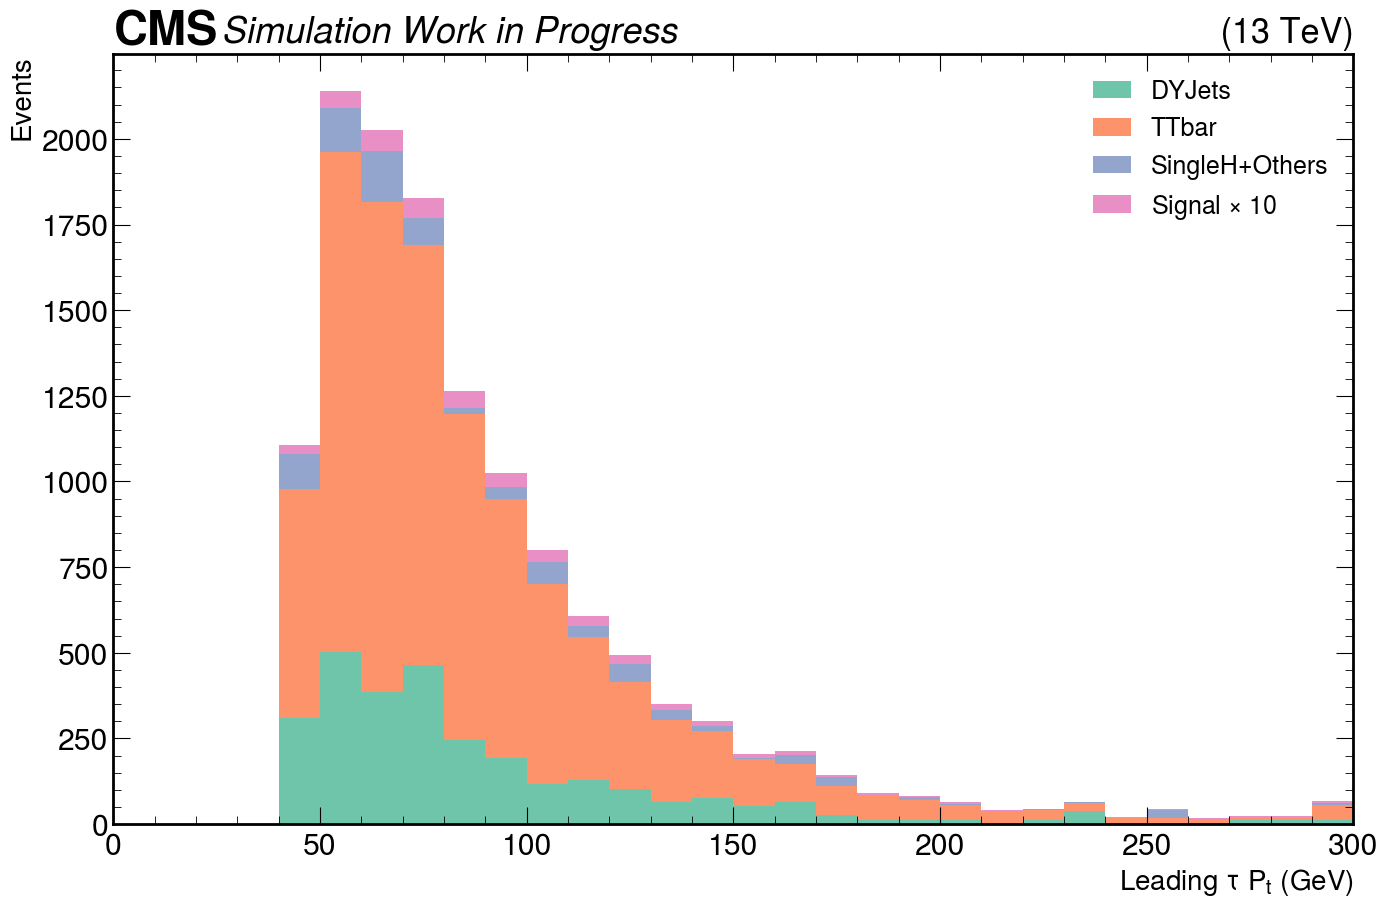

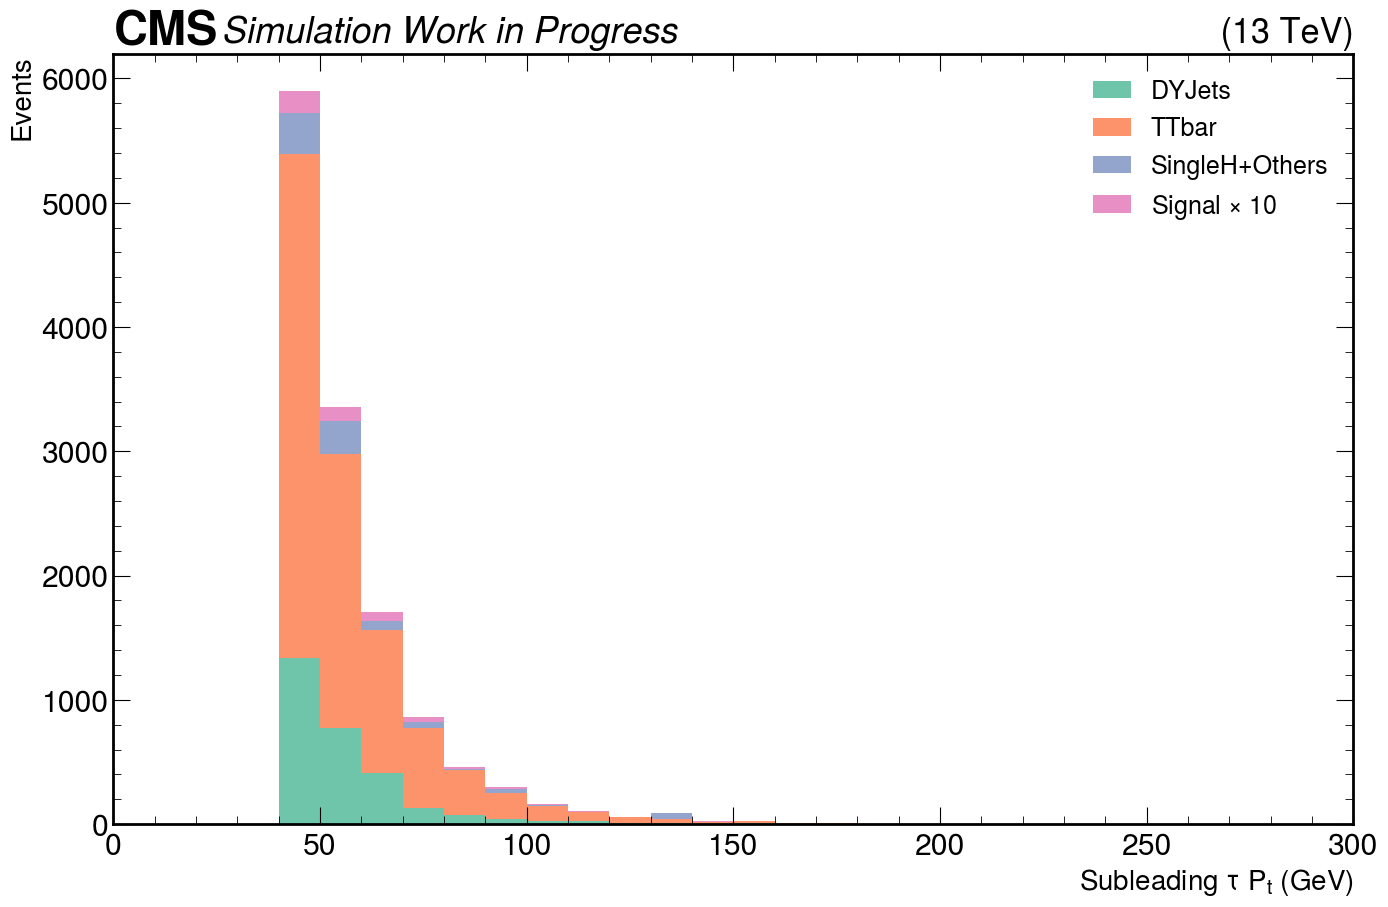

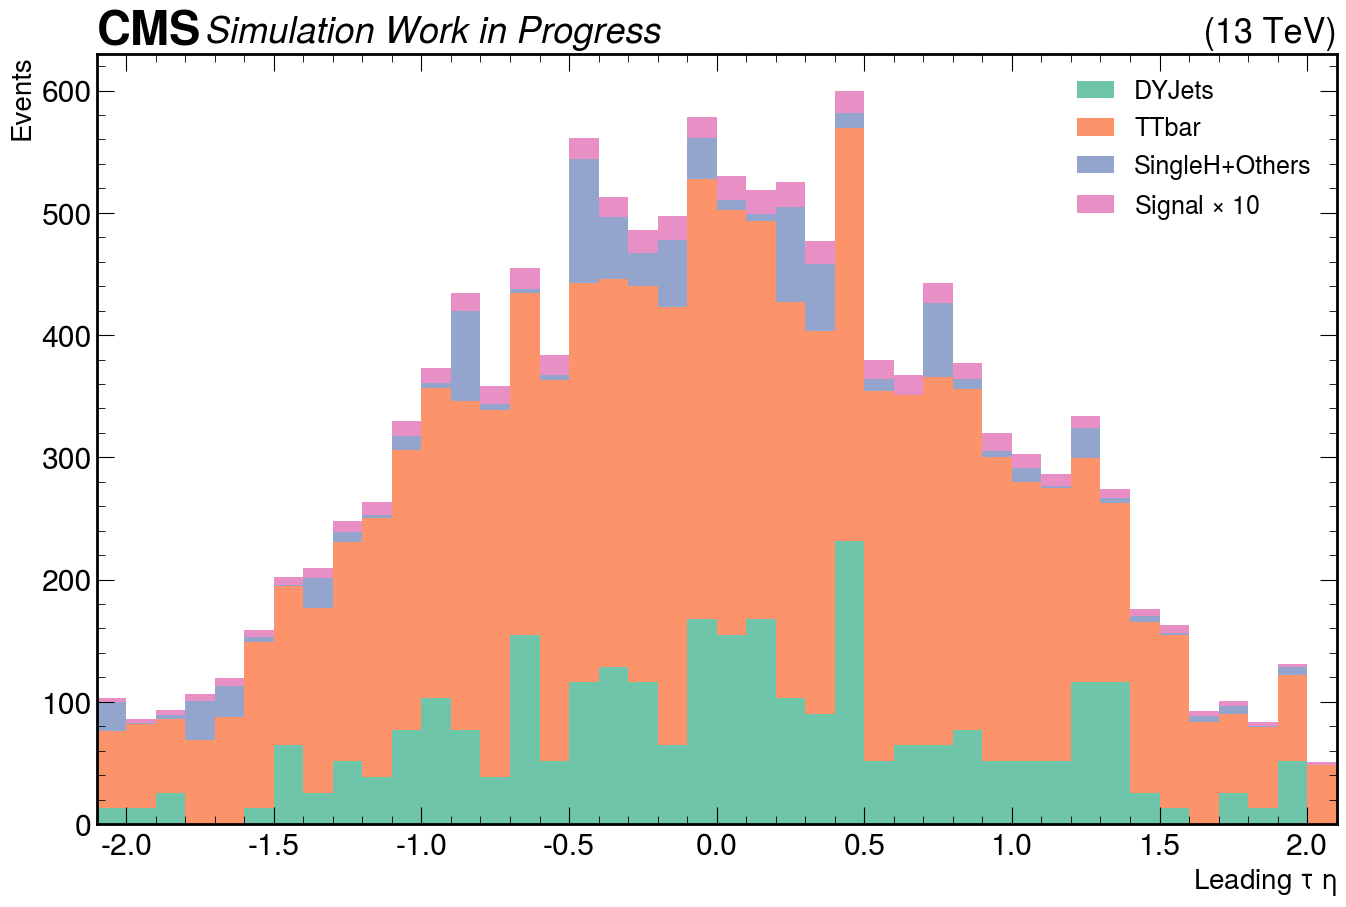

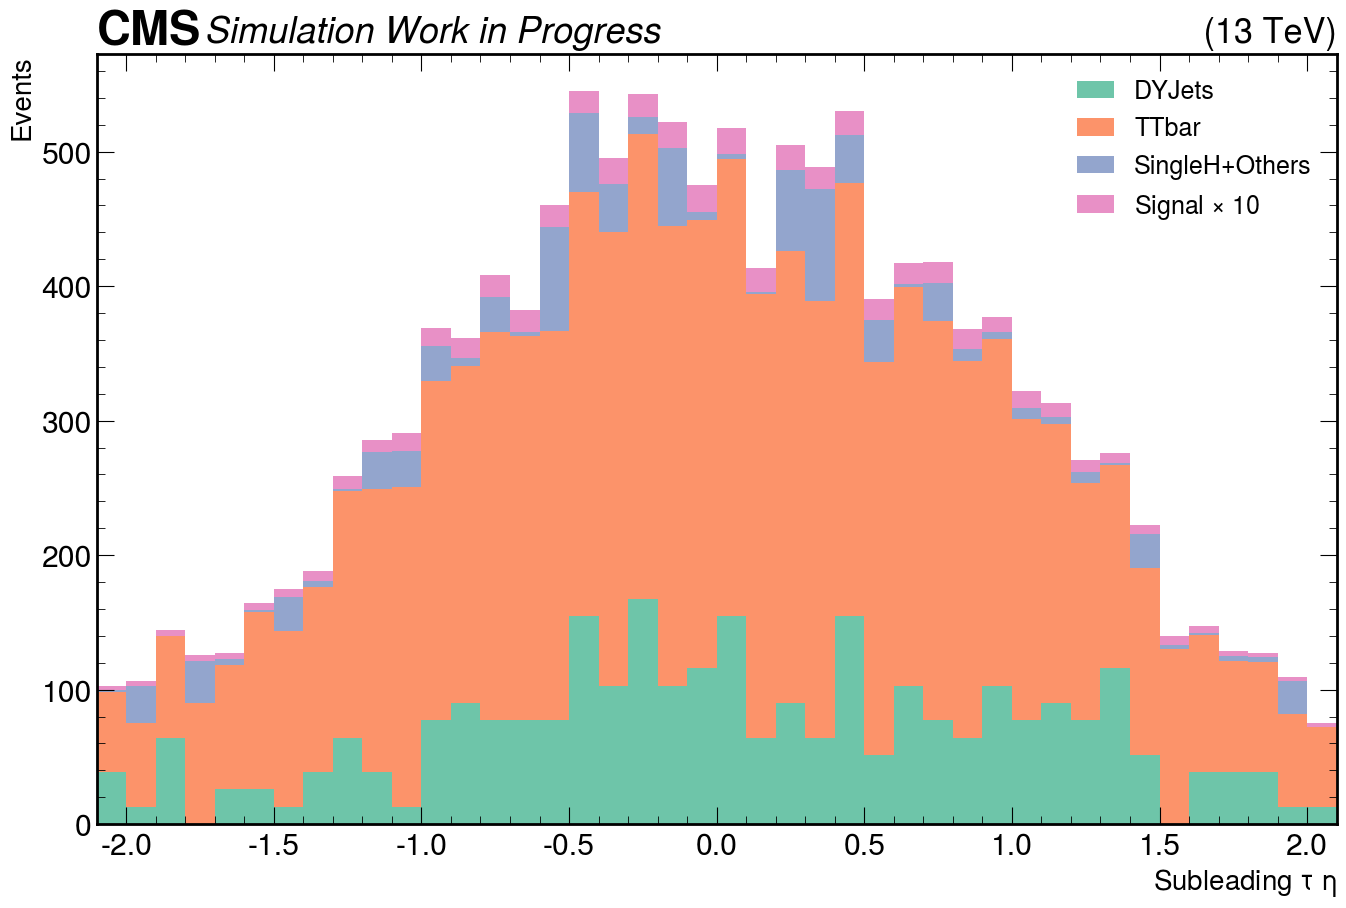

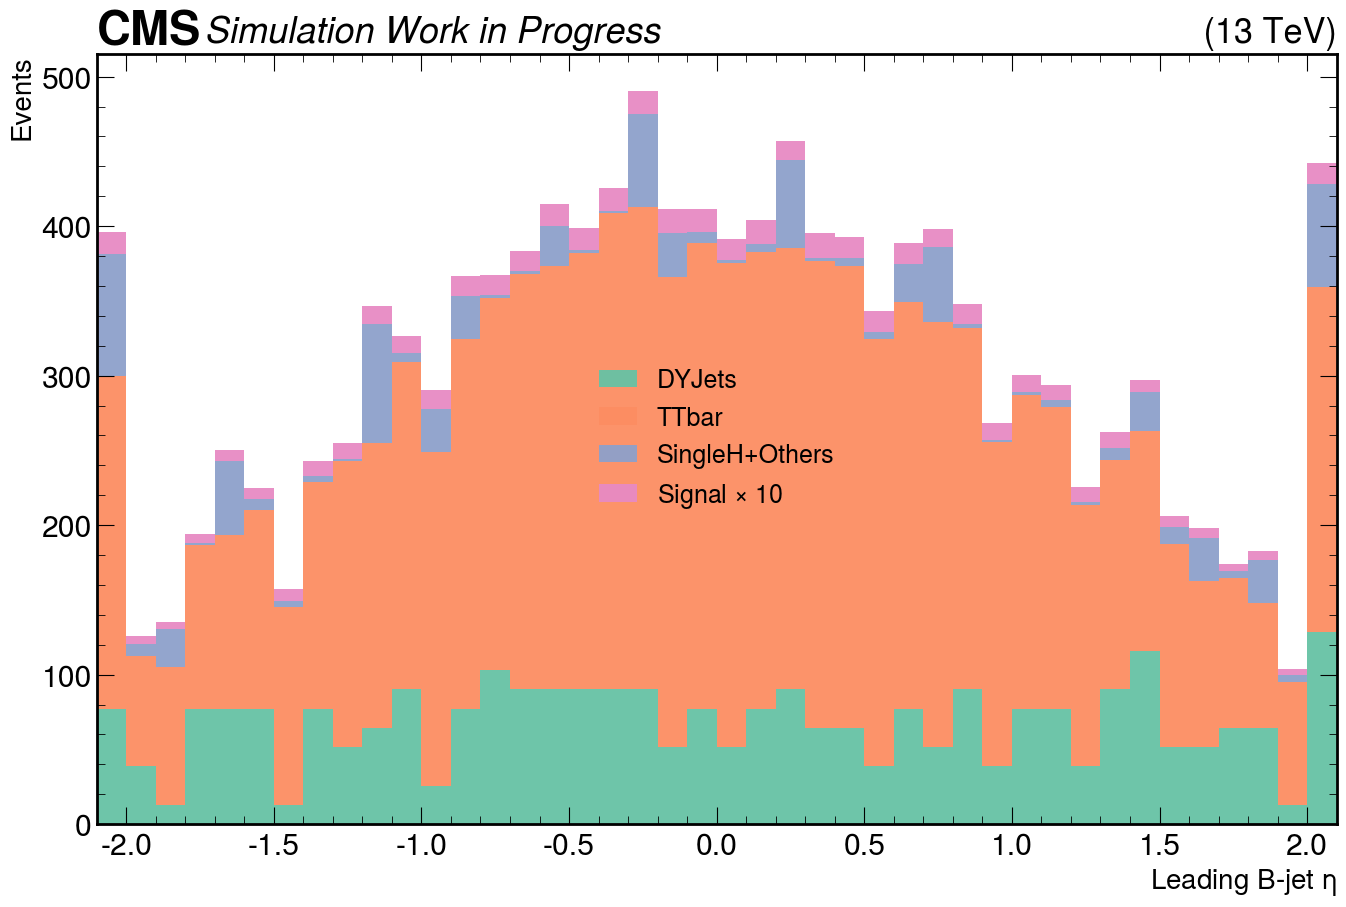

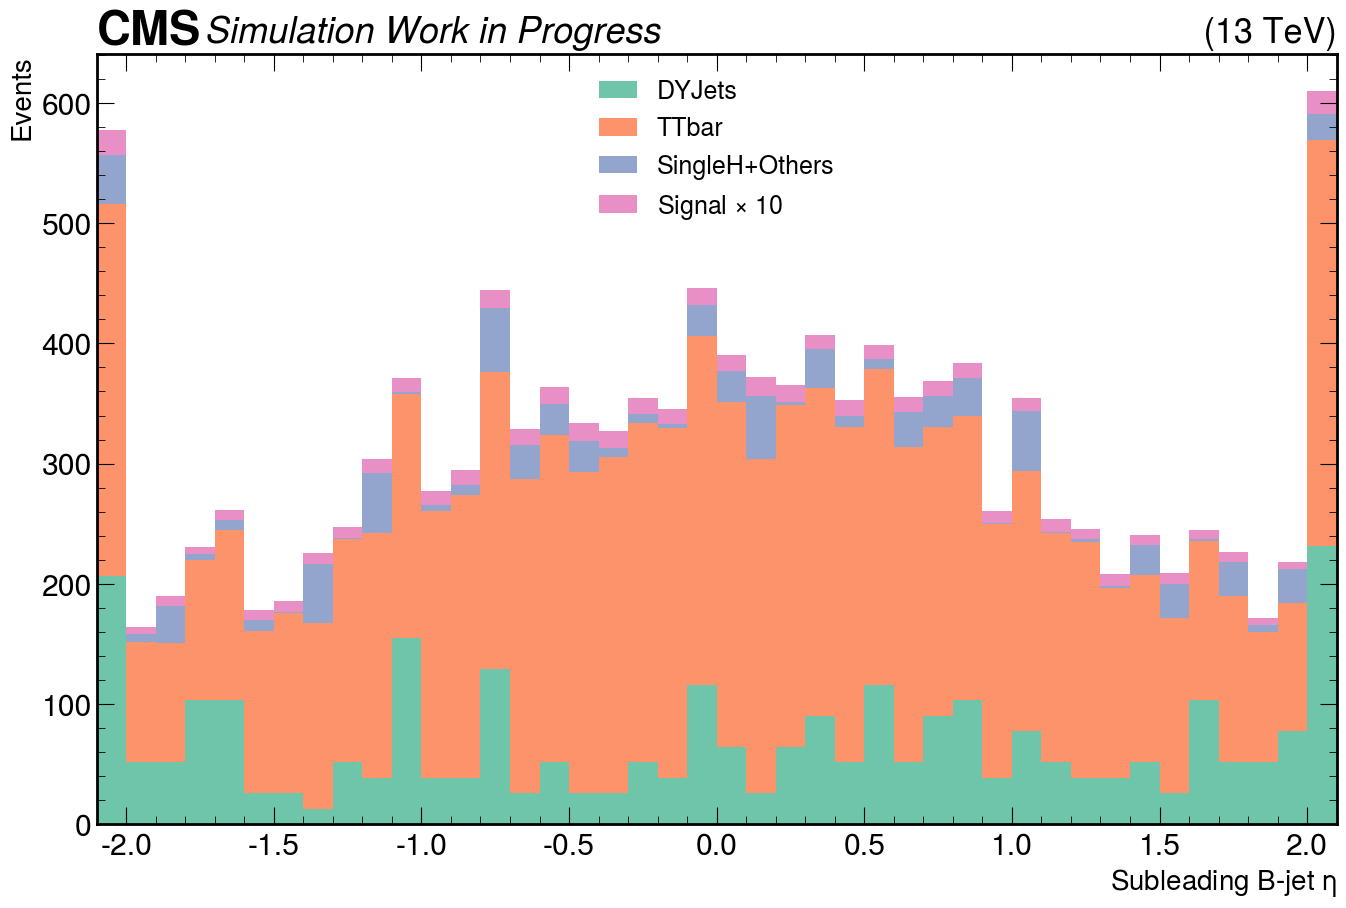

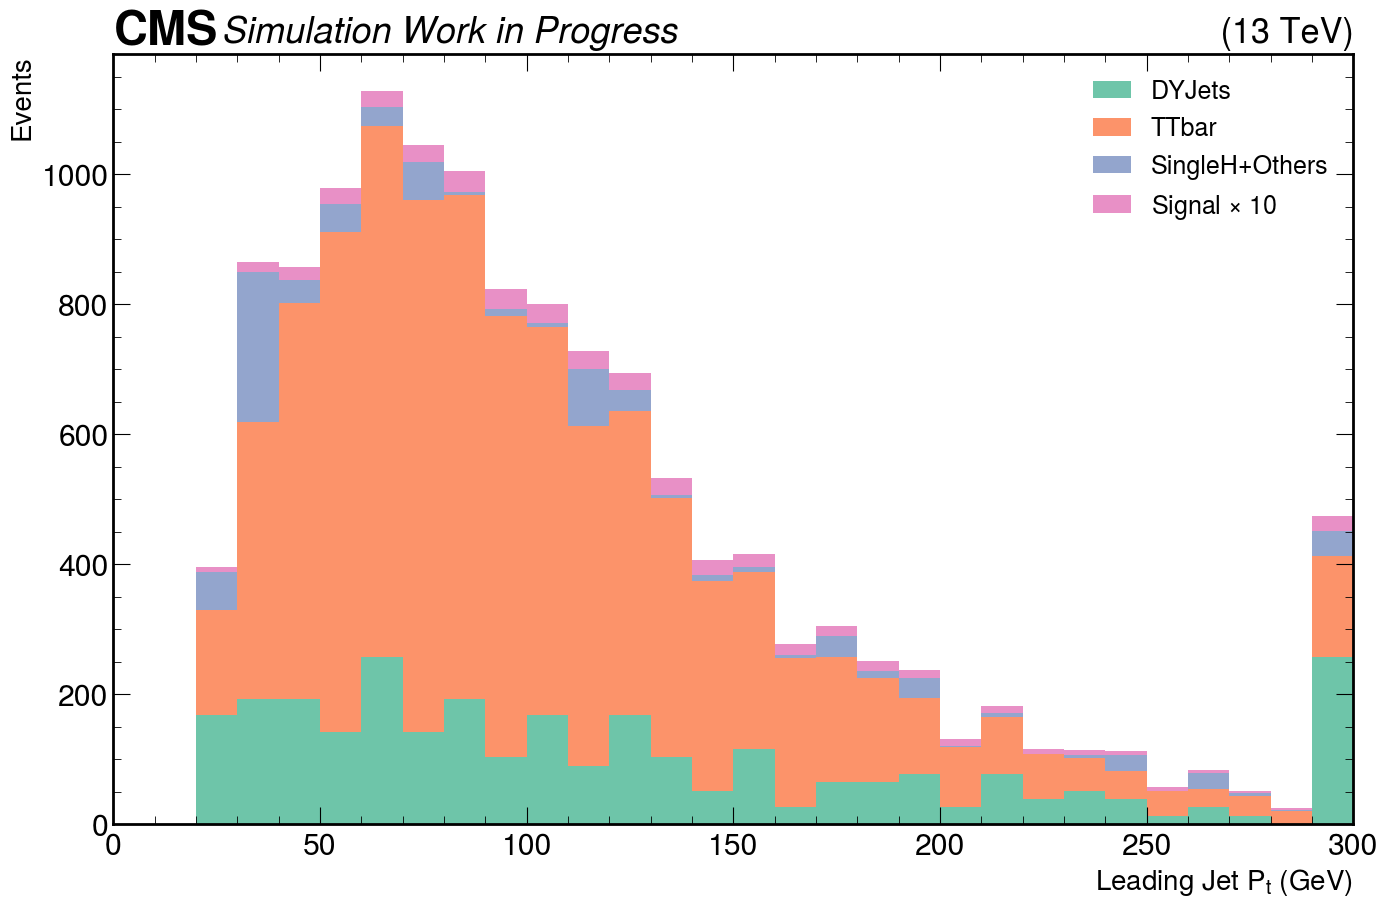

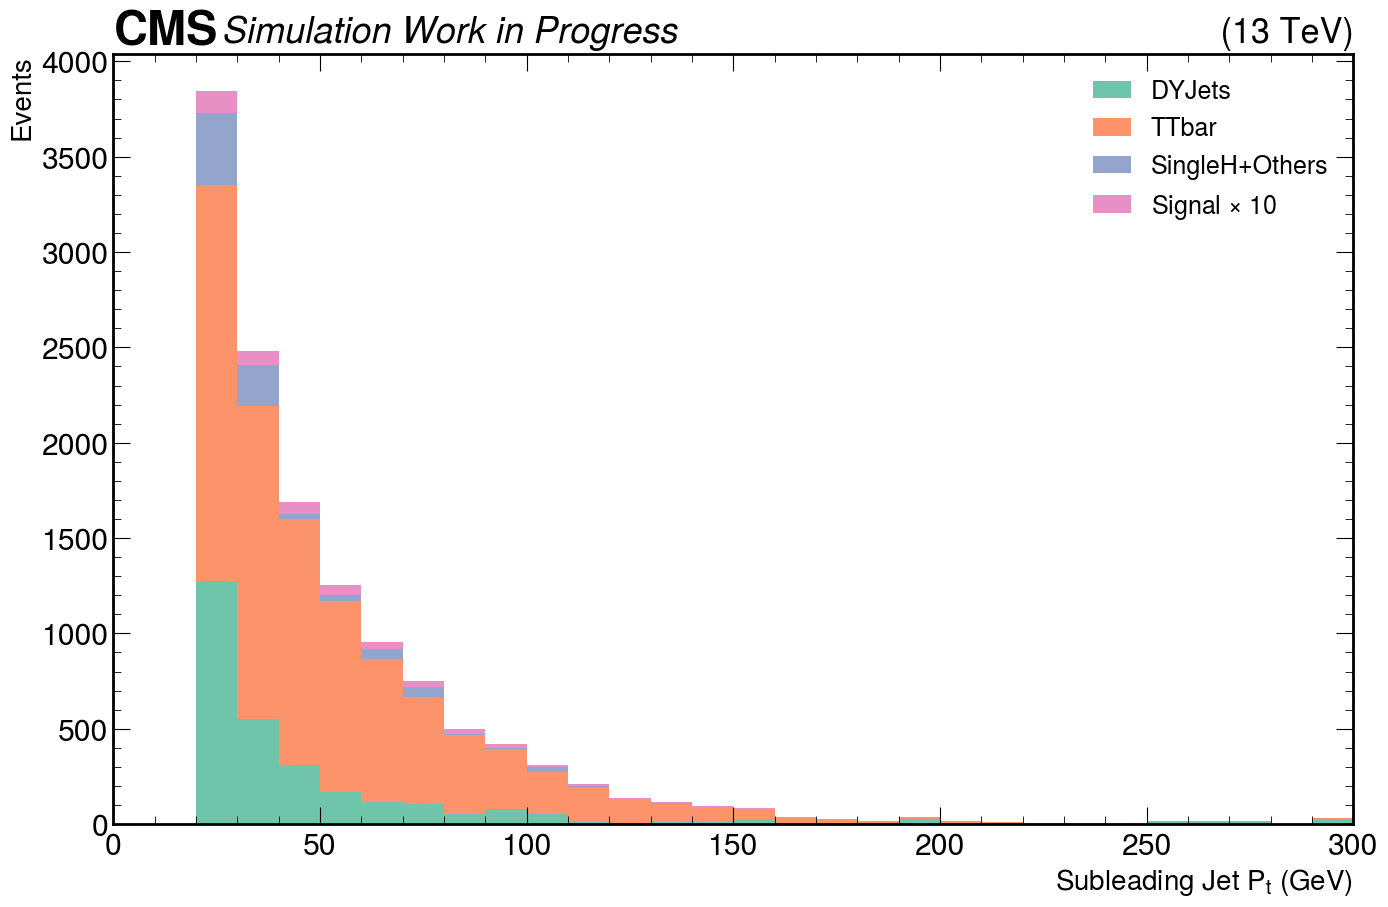

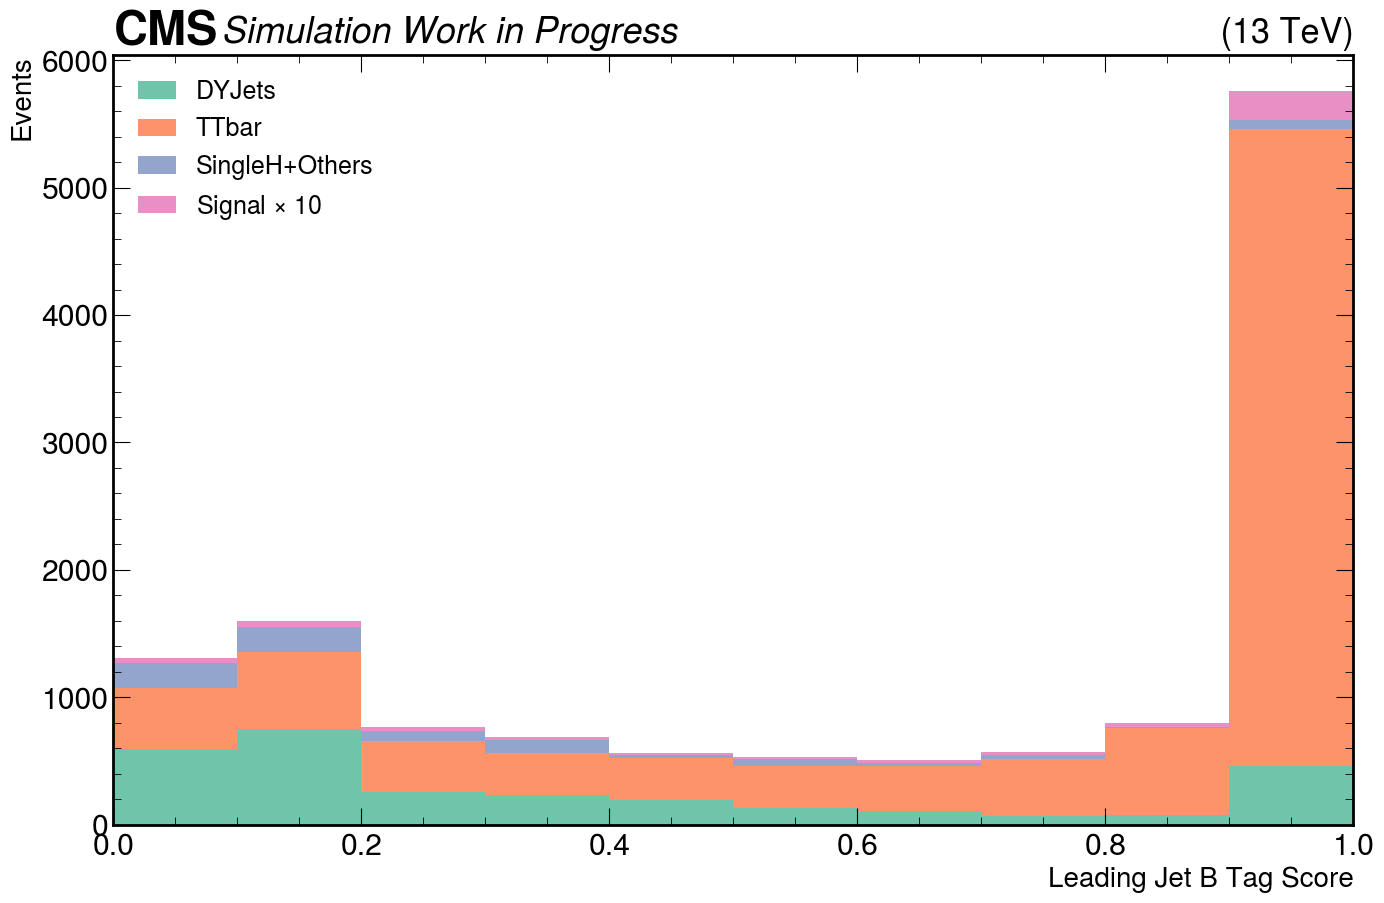

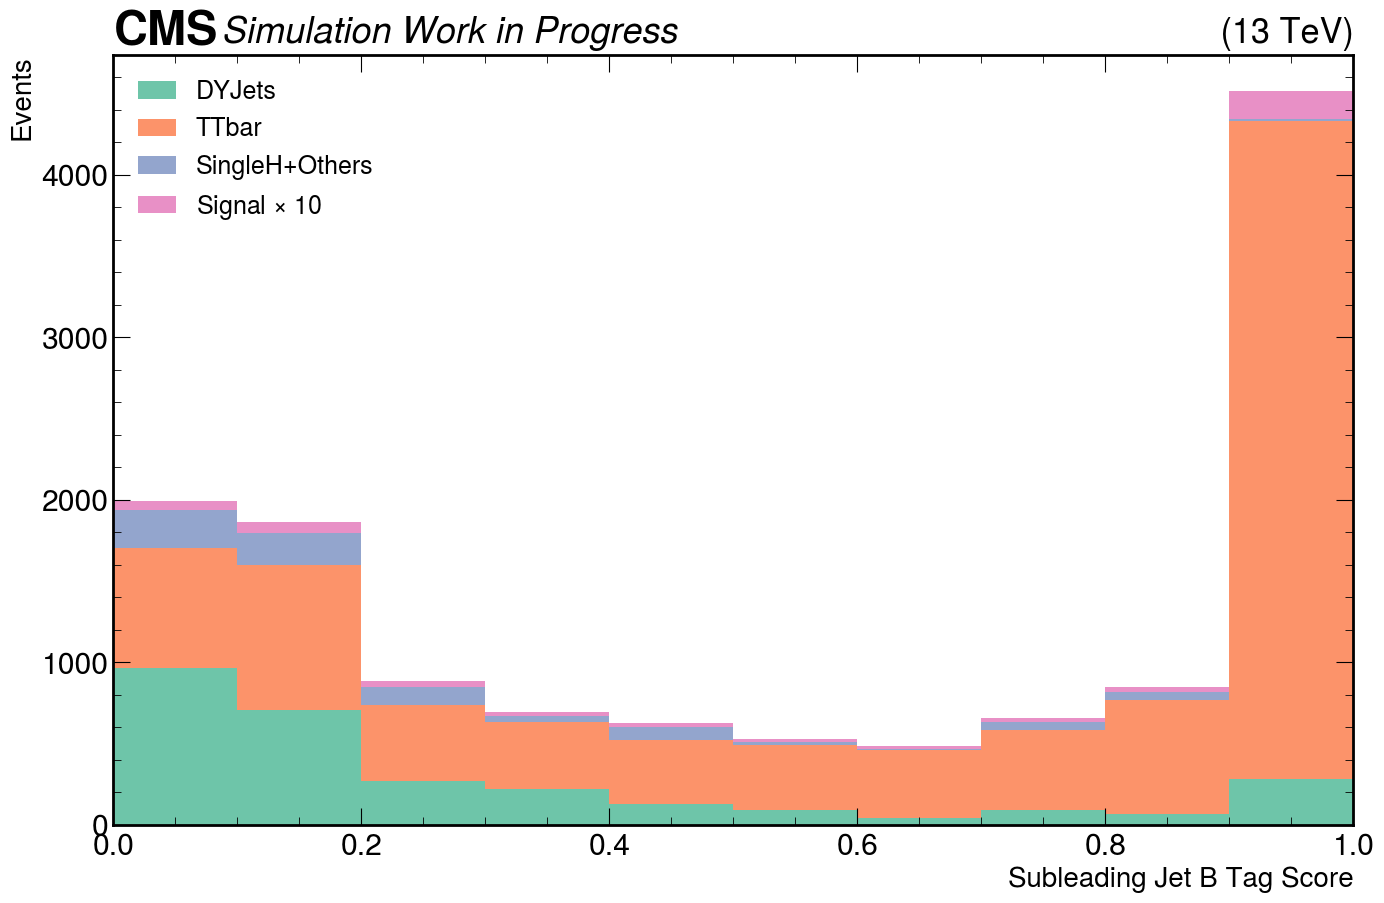

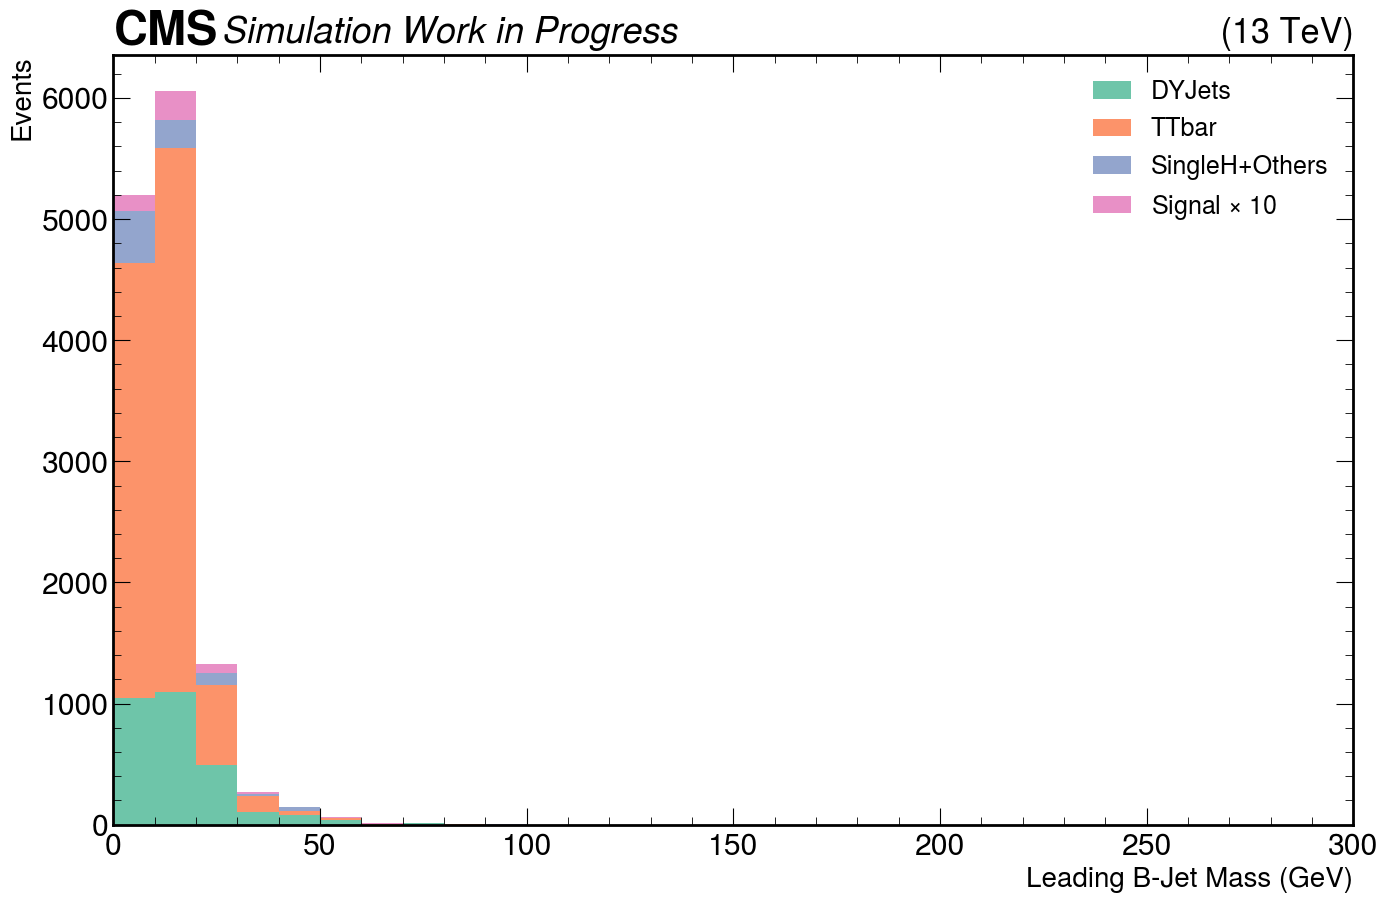

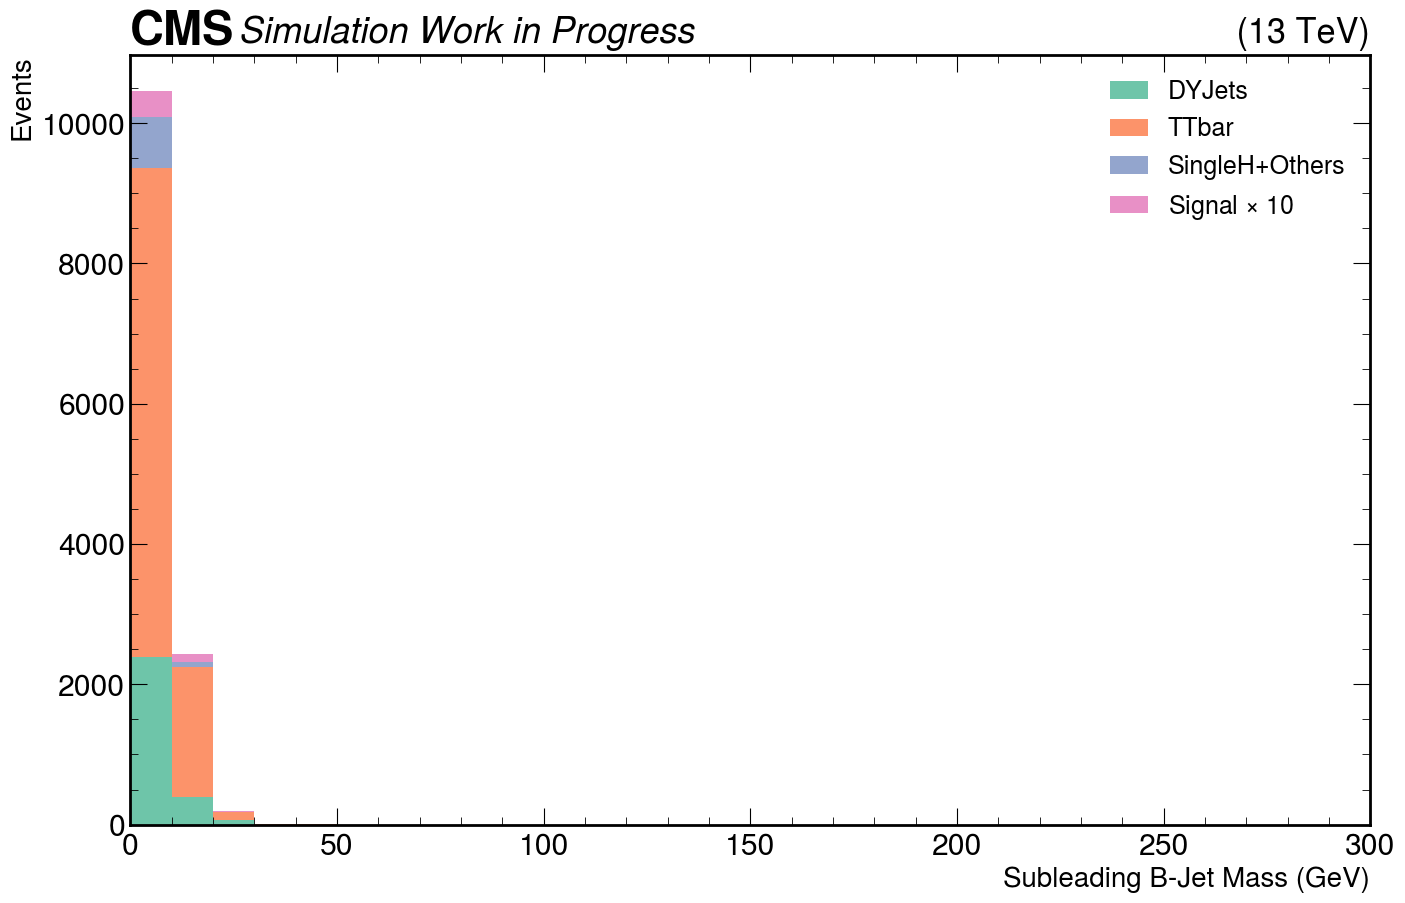

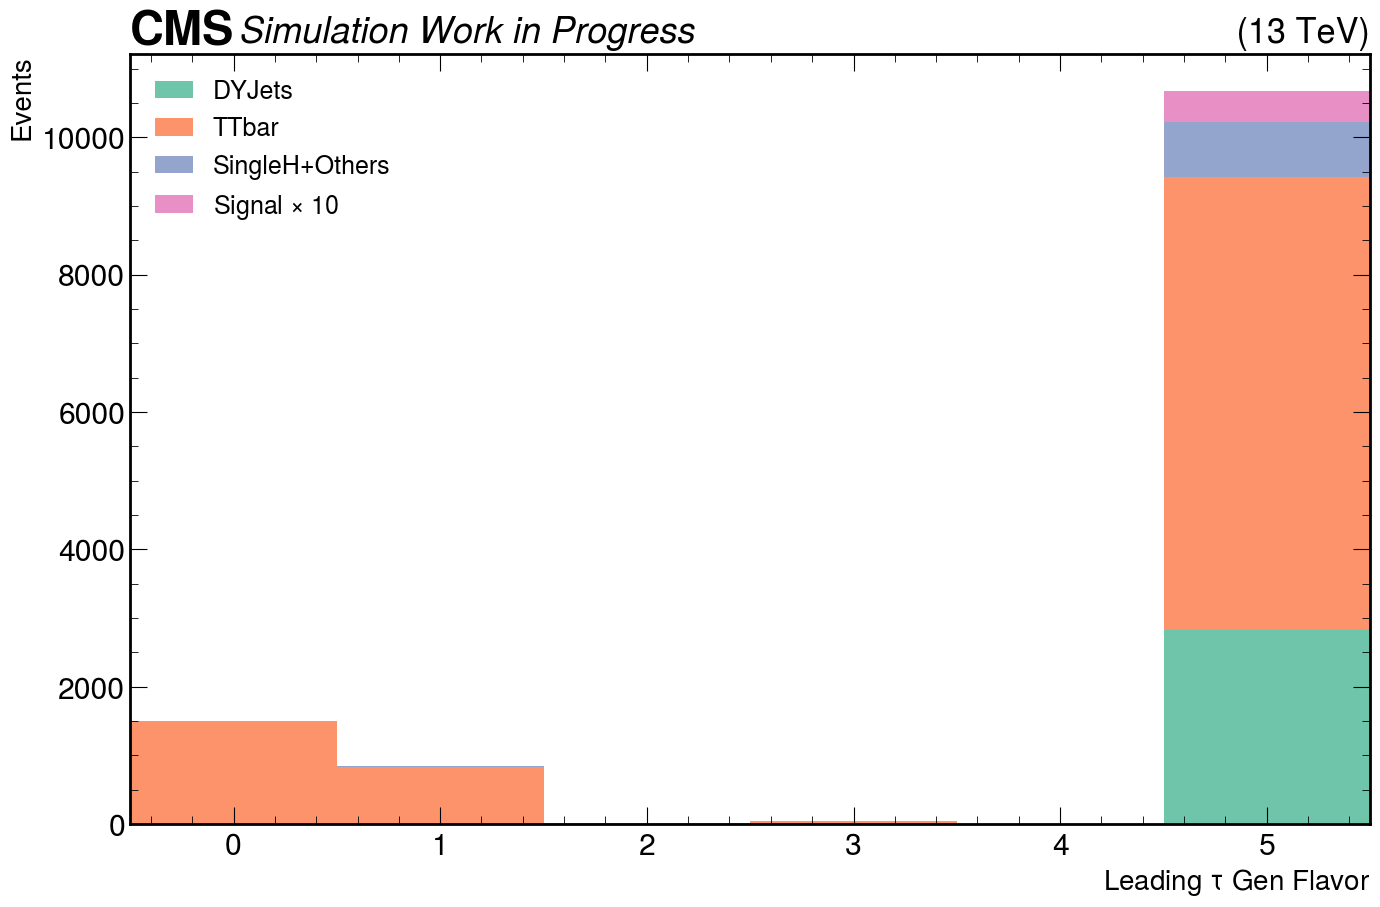

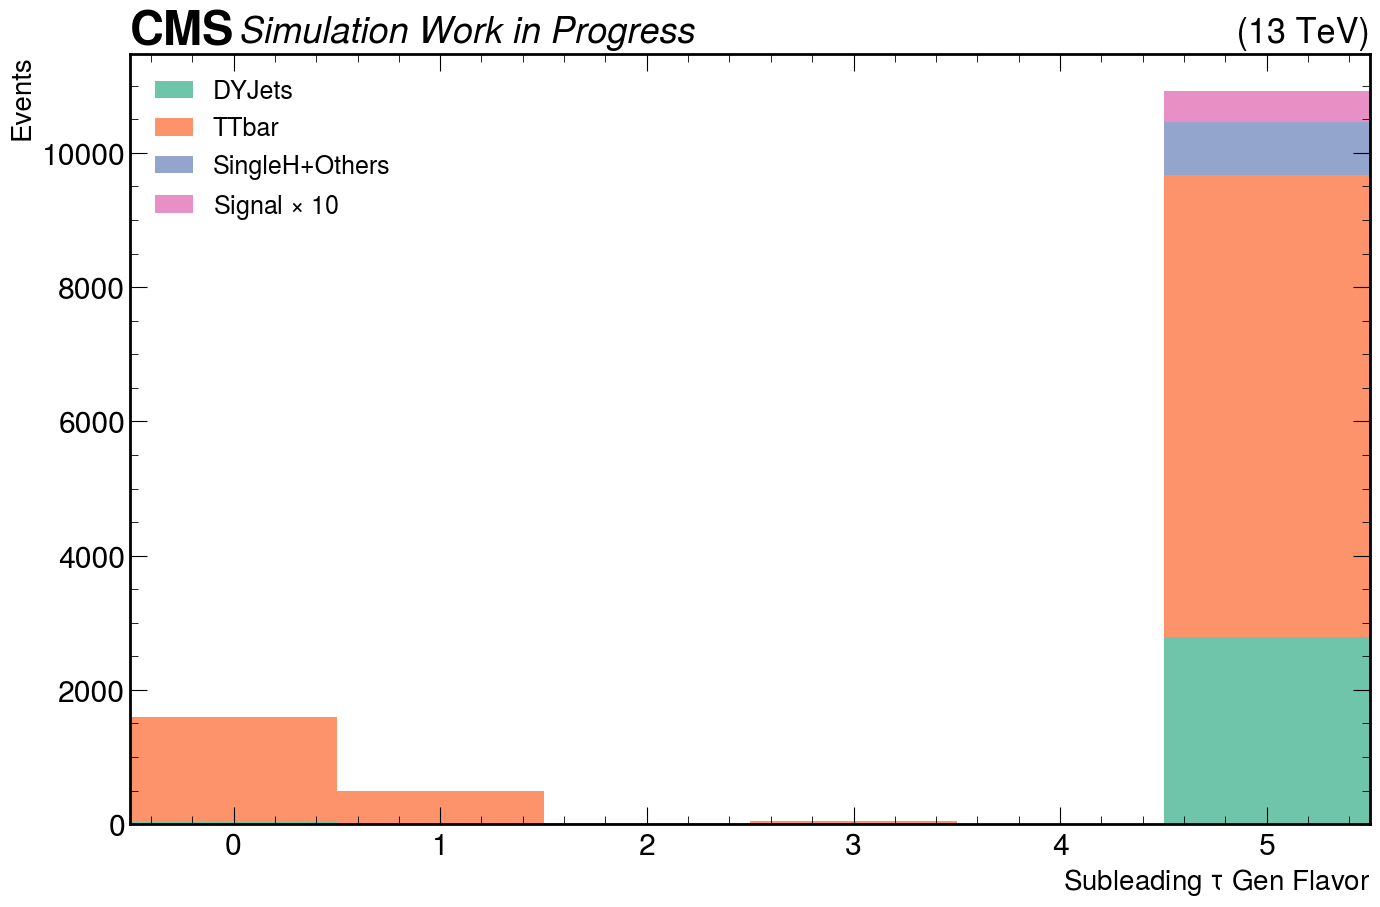

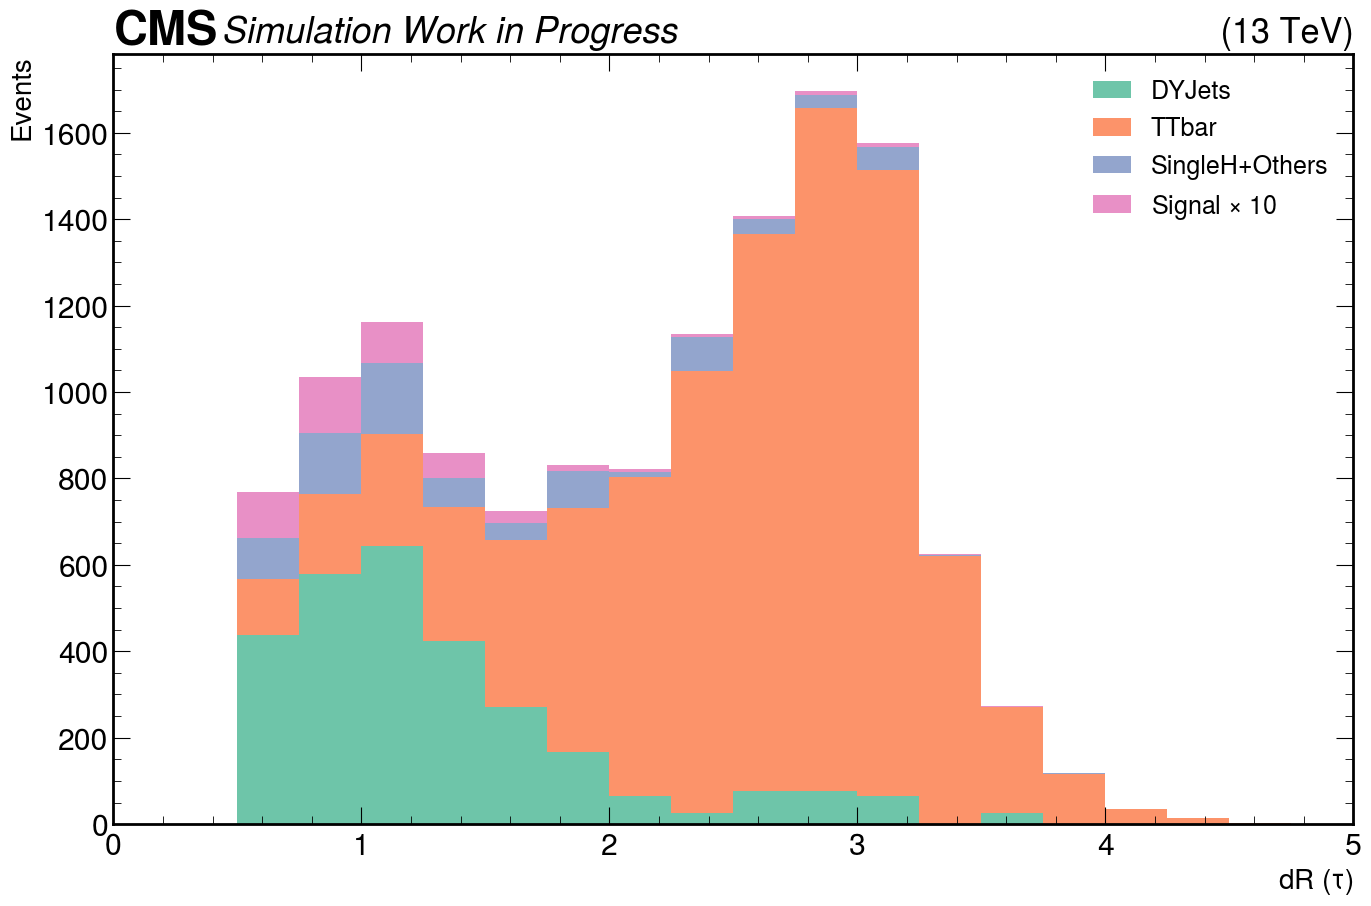

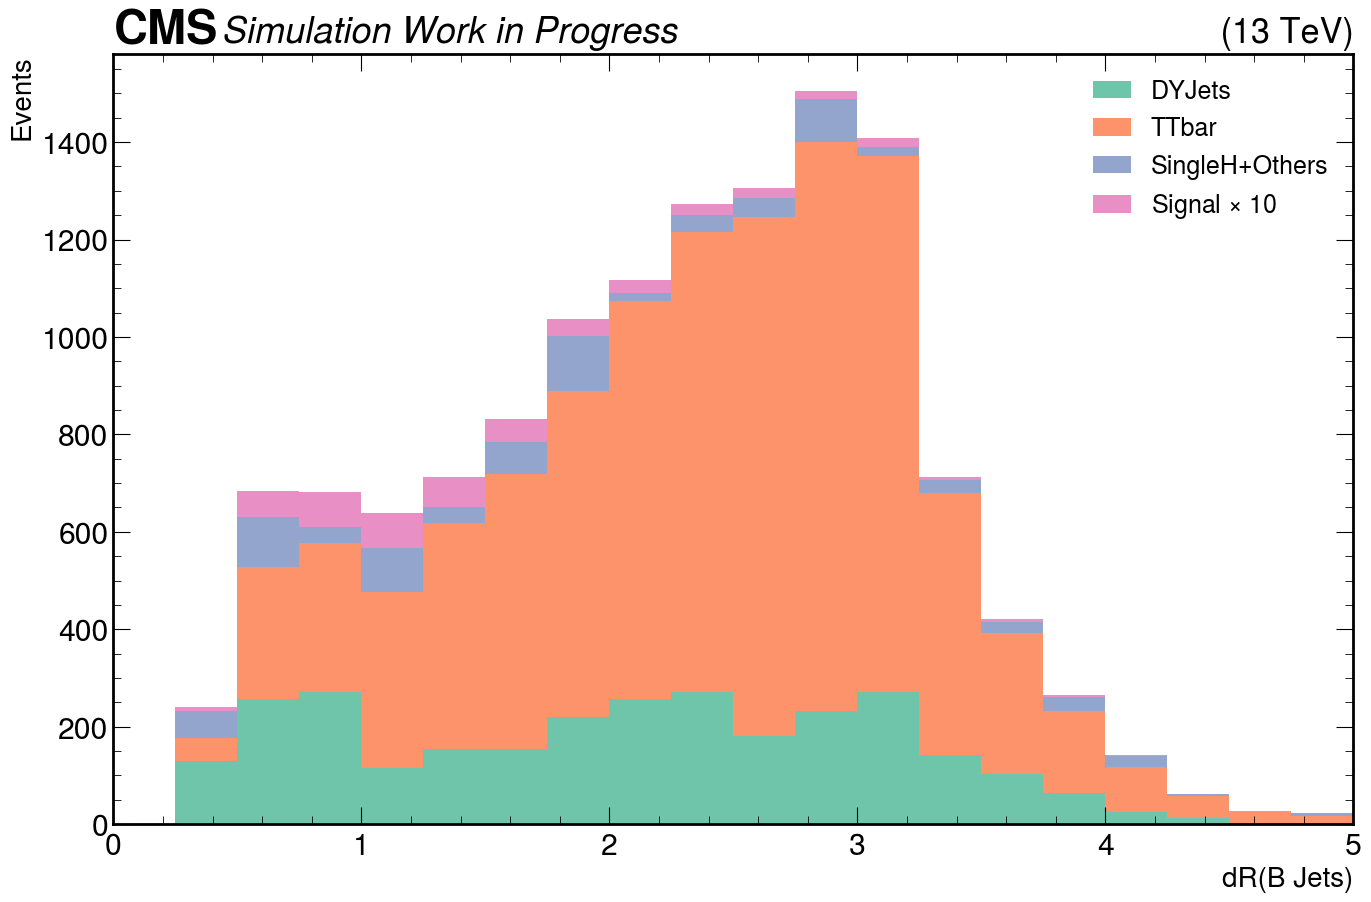

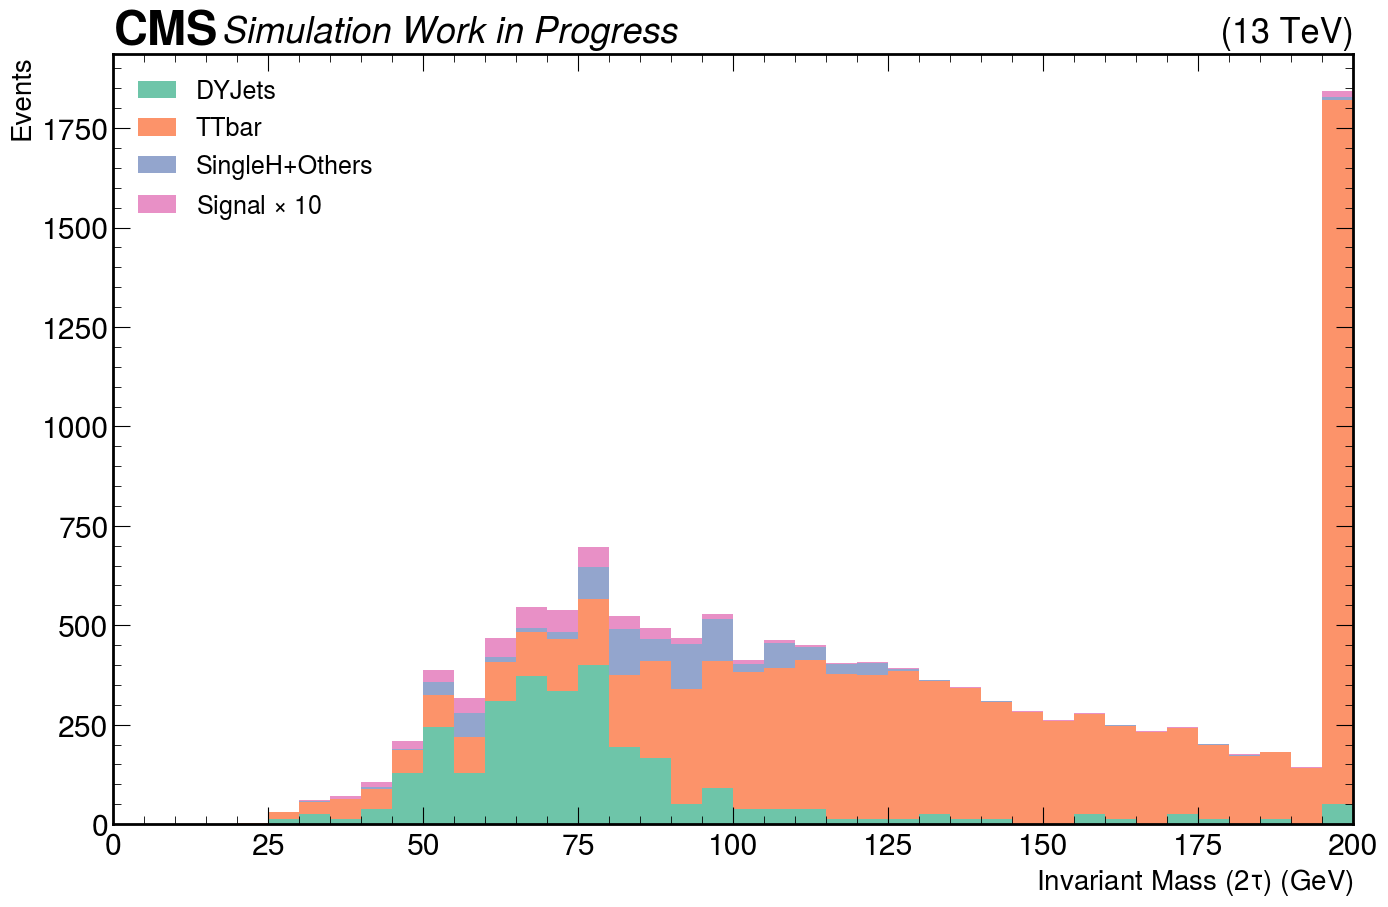

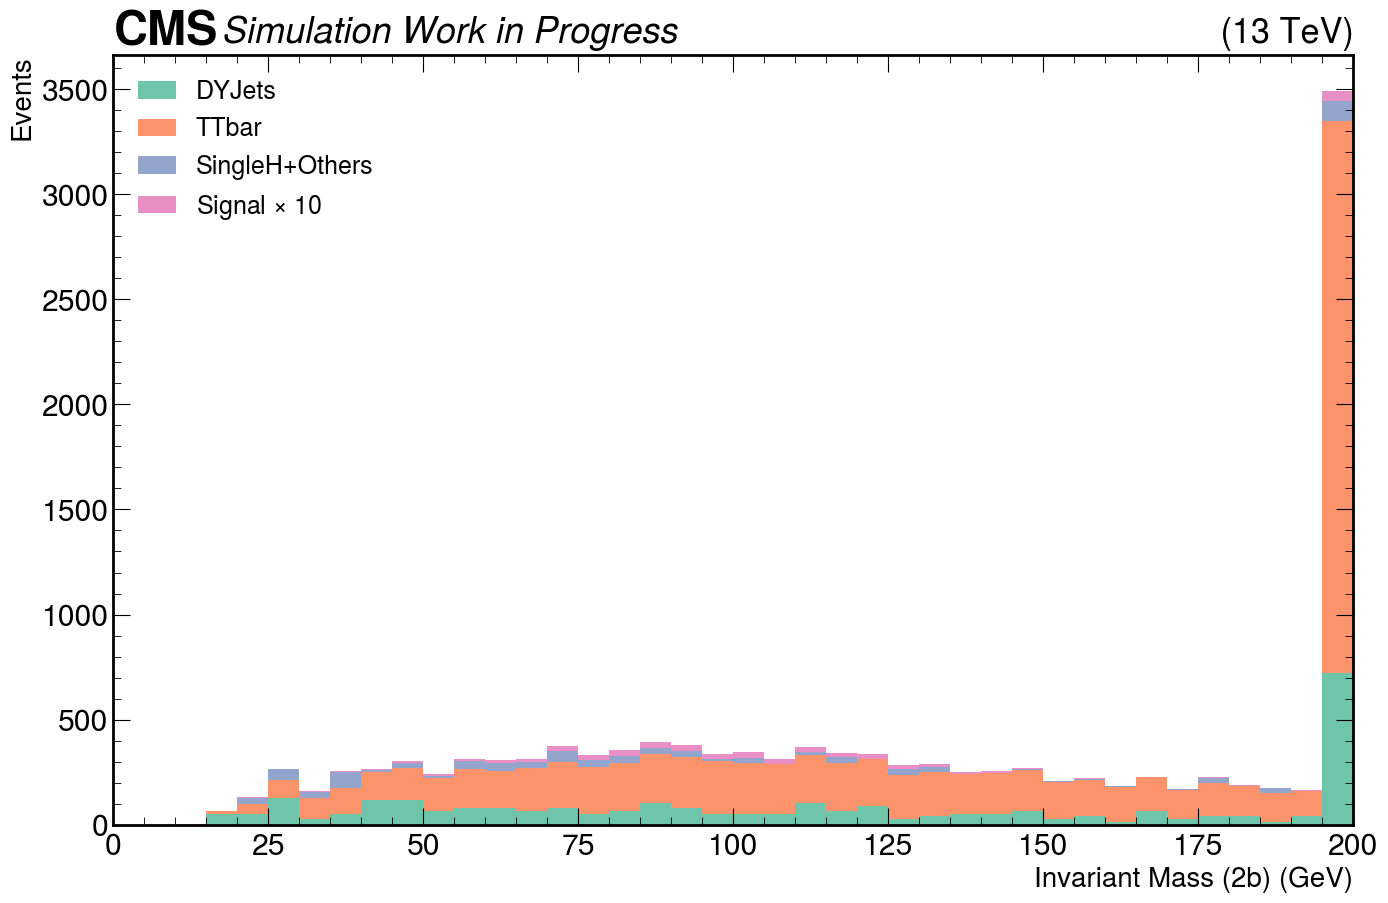

In [51]:
cp = CSVPlotter()
